# Построение дерева для описание кластеров

In [152]:
# работа с данными
import numpy as np
import pandas as pd

# класс дерева и визуализация
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# визуализация
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

## Подготовка датасета

Загрузка датасате, удаление NA

In [343]:
data = pd.read_csv("../data/data_for_clust_tree.csv")

In [326]:
data = data.dropna()

Создание нового датасета, где единица анализа - клиент, а не одна транзакция. Добавление новых фичей

In [327]:
sum_b = pd.DataFrame(data.groupby(by = "id")["sum_b"].mean()).reset_index().rename(index=str, columns = {'sum_b': "average_sum_b"})
sum_per_month = data[["id", "sum_per_month"]].drop_duplicates()
percent = pd.DataFrame(data.groupby(by = "id")["percent"].mean()).reset_index()
percent["if_bonus"] = np.where(percent["percent"] <= 0, 0, 1)
holiday_ratio = data.groupby(by = "id")['is_holiday'].mean().reset_index().rename(index=str, columns = {'is_holiday': "holiday_ratio"})
supliment_ratio = data.groupby(by = "id")['is_suplimentary'].mean().reset_index().rename(index=str, columns = {'is_holiday': "suplimentary_ratio"})
clusters = data[["id", "clust"]].drop_duplicates()

In [328]:
new_df = pd.merge(clusters, sum_b, on = "id")
new_df = pd.merge(new_df, sum_per_month, on = "id")
new_df = pd.merge(new_df, percent, on = "id")
new_df = pd.merge(new_df, holiday_ratio, on = "id")
new_df = pd.merge(new_df, supliment_ratio, on = "id")

In [329]:
new_df = new_df.drop(["average_sum_b", "if_bonus"], axis = 1).set_index("id")

In [330]:
new_df.shape

(5000, 6)

## Провекра фичей на важность

Разделение на трейн сет и таргет

In [331]:
X = new_df.drop(["clust"], axis = 1)
y = new_df.clust.astype(int)

Разбивка на тестовую и трейн части

In [332]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12)

Смотрим на важность фичей с помощью рандомного леса

In [132]:
random_forest = RandomForestClassifier(n_estimators = 100)

In [133]:
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [134]:
X_train.columns

Index(['sum_per_month', 'percent', 'holiday_ratio', 'is_suplimentary'], dtype='object')

In [135]:
random_forest.feature_importances_

array([ 0.26783157,  0.24964137,  0.23374179,  0.24878527])

## Построение дерева для описания

In [153]:
tree = DecisionTreeClassifier(random_state = 12)

Параметры для грид серча по сетке

In [200]:
tree_param = {"max_depth": np.arange(2, 9),
             "criterion": ["gini", "entropy"],
             "min_samples_split": [2,4,6,8],
             "min_samples_leaf": np.arange(5, 100, 15)}

In [201]:
tree_grid = GridSearchCV(tree, param_grid = tree_param, cv = 5, n_jobs = - 1)

In [202]:
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=12,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([2, 3, 4, 5, 6, 7, 8]), 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 4, 6, 8], 'min_samples_leaf': array([ 5, 20, 35, 50, 65, 80, 95])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [203]:
new_tree = tree_grid.best_estimator_

In [210]:
accuracy_score(y_test, new_tree.predict(X_test))

0.40928092176906594

## Визуализация дерева

In [205]:
export_graphviz(new_tree, feature_names=X_train.columns, 
out_file= "../pngs/tree_2.dot", filled=True)
!dot -Tpng ../pngs/tree_2.dot -o ../pngs/tree_2.png

## Сравнение кластеров

In [334]:
df_desc = pd.merge(X_train.reset_index(), y_train.reset_index(), on = "id").set_index('id')

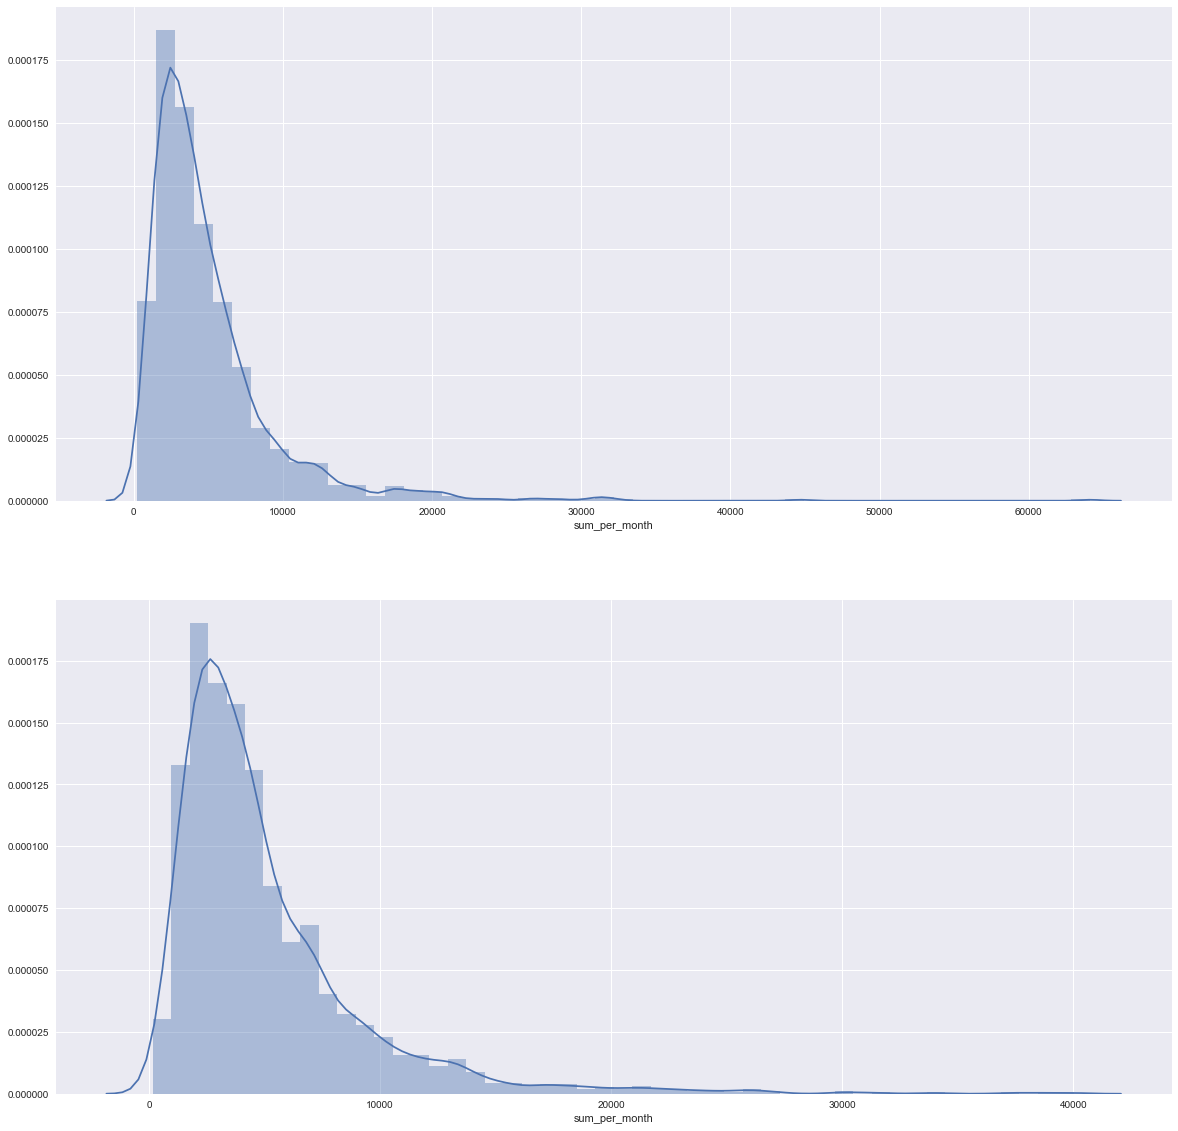

In [339]:
fig, ax = plt.subplots(4, 1, figsize = (20, 20))

for i in range(4):
    sns.distplot(df_desc[df_desc["clust"] == i]["sum_per_month"], ax = ax[i])

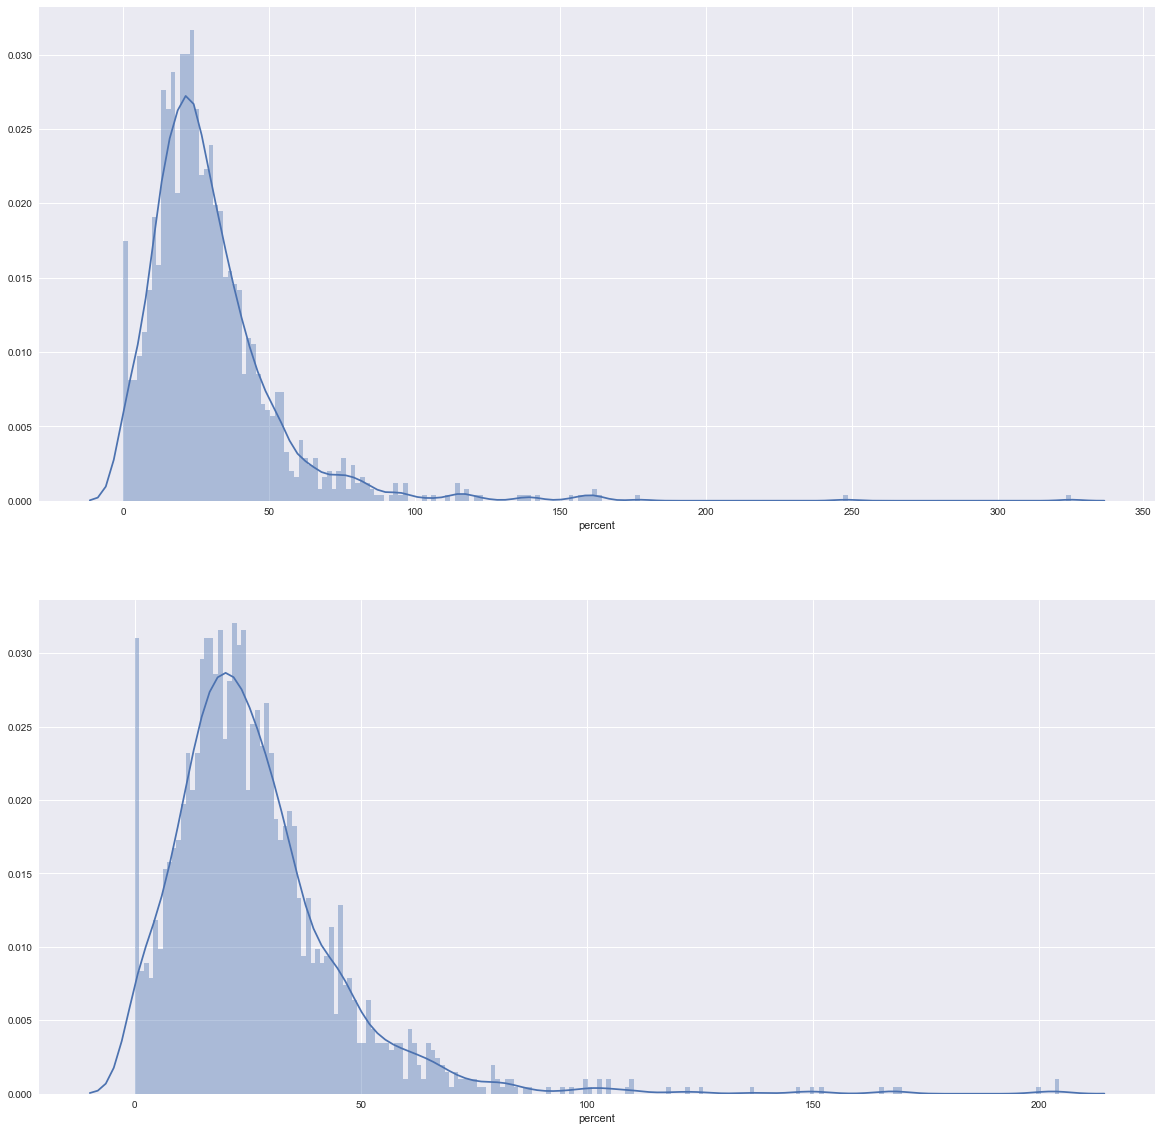

In [340]:
fig, ax = plt.subplots(4, 1, figsize = (20, 20))

for i in range(4):
    sns.distplot(df_desc[df_desc["clust"] == i]["percent"] , bins = 200, ax = ax[i])

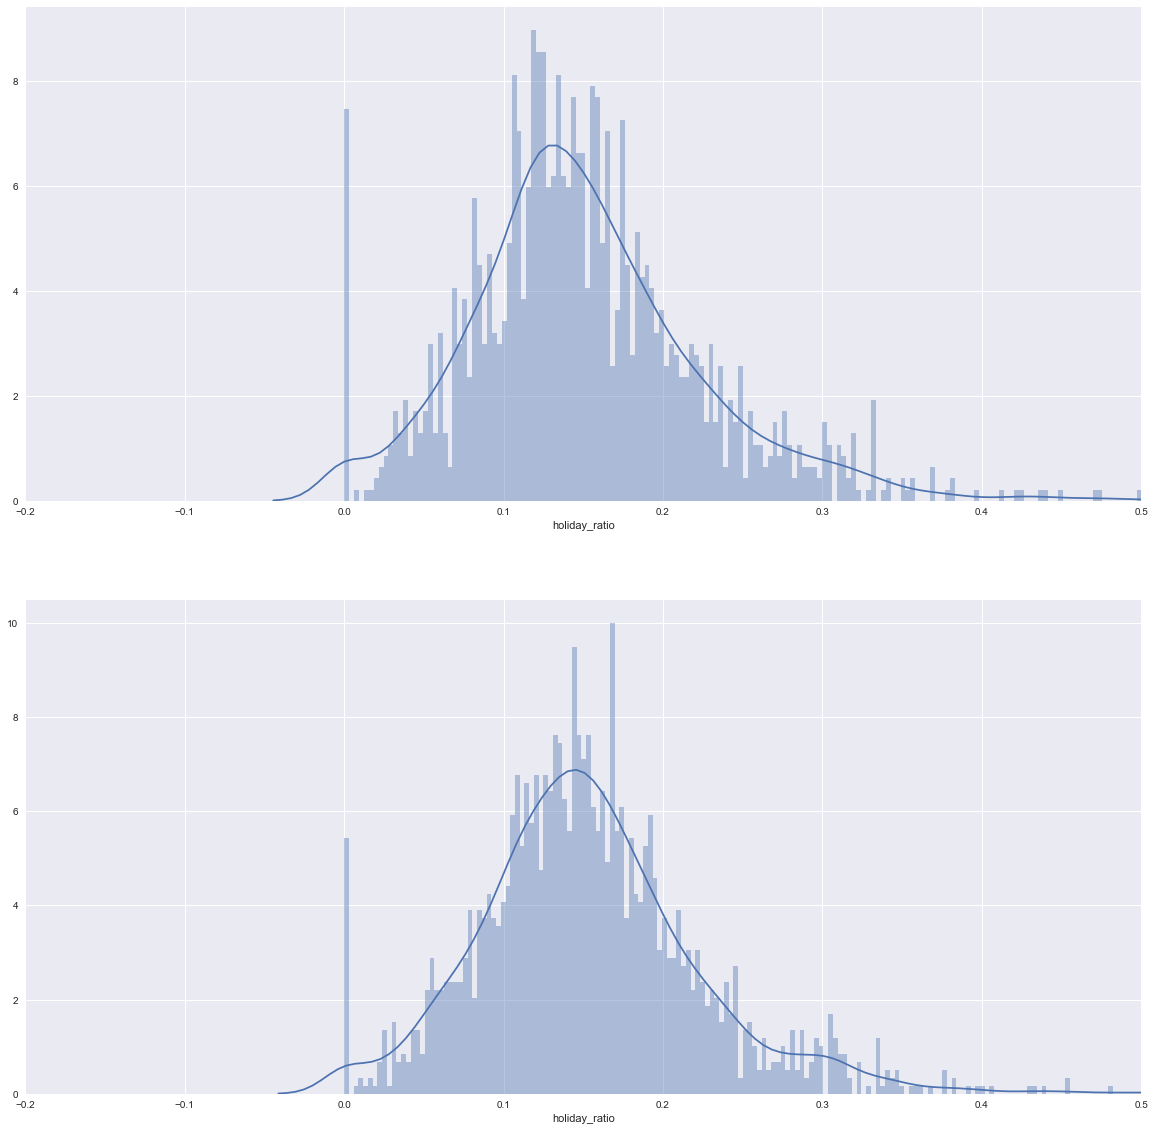

In [341]:
fig, ax = plt.subplots(4, 1, figsize = (20, 20))

for i in range(4):
    sns.distplot(df_desc[df_desc["clust"] == i]["holiday_ratio"] , bins = 200, ax = ax[i])
    ax[i].set_xlim(-0.2, 0.5)

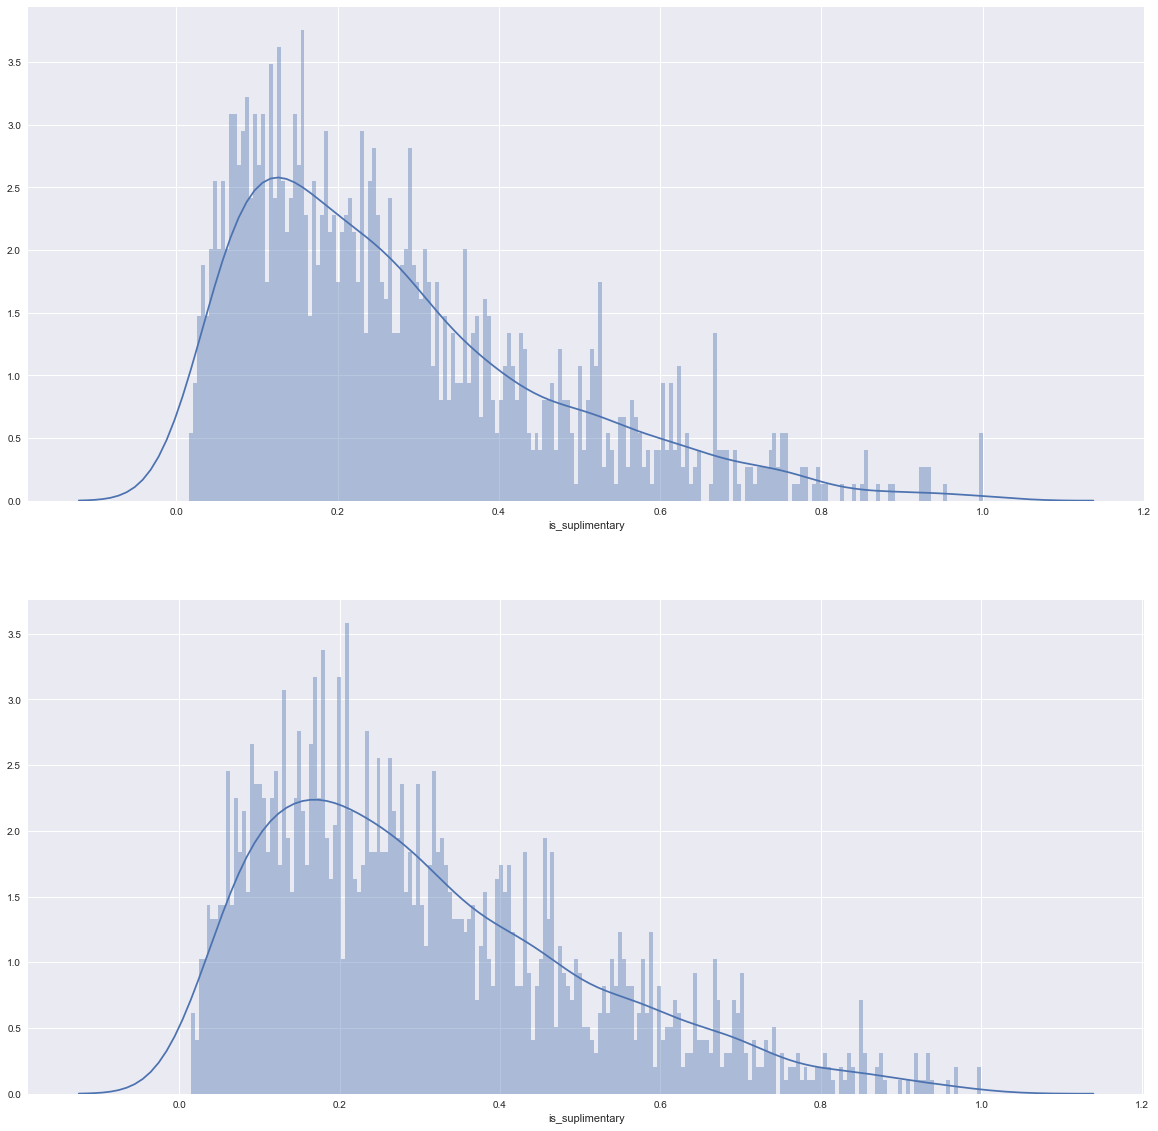

In [342]:
fig, ax = plt.subplots(4, 1, figsize = (20, 20))

for i in range(4):
    sns.distplot(df_desc[df_desc["clust"] == i]["is_suplimentary"] , bins = 200, ax = ax[i])